In [2]:
import time
import re

import numpy as np
import pandas as pd

import tensorflow as tf
print(tf.__version__)

from matplotlib import pyplot as plt

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\damic\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-b3198b2150da>", line 7, in <module>
    import tensorflow as tf
  File "C:\Users\damic\anaconda3\lib\site-packages\tensorflow\__init__.py", line 101, in <module>
    from tensorflow_core import *
  File "C:\Users\damic\anaconda3\lib\site-packages\tensorflow_core\__init__.py", line 40, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "C:\Users\damic\anaconda3\lib\site-packages\tensorflow\__init__.py", line 50, in __getattr__
    module = self._load()
  File "C:\Users\damic\anaconda3\lib\site-packages\tensorflow\__init__.py", line 44, in _load
    module = _importlib.import_module(self.__name__)
  File "C:\Users\damic\anaconda3\lib\importlib\__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], pa

ModuleNotFoundError: No module named 'gast'

In [8]:
# Read the Divina Commedia
with open("C:/Users/damic/Desktop/DivinaCommedia.txt", 'r') as file:
    divina_commedia = file.read()

# Replace rare characters
divina_commedia = divina_commedia.replace("ä", "a")
divina_commedia = divina_commedia.replace("é", "è")
divina_commedia = divina_commedia.replace("ë", "è")
divina_commedia = divina_commedia.replace("Ë", "E")
divina_commedia = divina_commedia.replace("ï", "i")
divina_commedia = divina_commedia.replace("Ï", "I")
divina_commedia = divina_commedia.replace("ó", "ò")
divina_commedia = divina_commedia.replace("ö", "o")
divina_commedia = divina_commedia.replace("ü", "u")

divina_commedia = divina_commedia.replace("(", "-")
divina_commedia = divina_commedia.replace(")", "-")
divina_commedia = divina_commedia.replace("[", "")
divina_commedia = divina_commedia.replace("]", "")

divina_commedia = re.sub(r'[0-9]+', '', divina_commedia)
divina_commedia = divina_commedia.replace(" \n", "\n")

In [9]:
# Check lenght of text
print(len(divina_commedia))

551704


In [10]:
# Store unique characters into a dict with numerical encoding
unique_chars = list(set(divina_commedia))
unique_chars.sort()  # to make sure you get the same encoding at each run

# Store them in a dict, associated with a numerical index
char2idx = { char[1]: char[0] for char in enumerate(unique_chars) }


In [11]:
print(len(char2idx))

63


In [12]:
char2idx

{'\n': 0,
 ' ': 1,
 '!': 2,
 '"': 3,
 "'": 4,
 ',': 5,
 '-': 6,
 '.': 7,
 ':': 8,
 ';': 9,
 '?': 10,
 'A': 11,
 'B': 12,
 'C': 13,
 'D': 14,
 'E': 15,
 'F': 16,
 'G': 17,
 'H': 18,
 'I': 19,
 'L': 20,
 'M': 21,
 'N': 22,
 'O': 23,
 'P': 24,
 'Q': 25,
 'R': 26,
 'S': 27,
 'T': 28,
 'U': 29,
 'V': 30,
 'X': 31,
 'Z': 32,
 'a': 33,
 'b': 34,
 'c': 35,
 'd': 36,
 'e': 37,
 'f': 38,
 'g': 39,
 'h': 40,
 'i': 41,
 'j': 42,
 'l': 43,
 'm': 44,
 'n': 45,
 'o': 46,
 'p': 47,
 'q': 48,
 'r': 49,
 's': 50,
 't': 51,
 'u': 52,
 'v': 53,
 'x': 54,
 'y': 55,
 'z': 56,
 'È': 57,
 'à': 58,
 'è': 59,
 'ì': 60,
 'ò': 61,
 'ù': 62}

In [13]:
def numerical_encoding(text, char_dict):
    """ Text to list of chars, to np.array of numerical idx """
    chars_list = [ char for char in text ]
    chars_list = [ char_dict[char] for char in chars_list ]
    chars_list = np.array(chars_list)
    return chars_list


In [14]:
# Let's see what the first line will look like
print("{}".format(divina_commedia[276:311]))
print("\nbecomes:")
print(numerical_encoding(divina_commedia[276:311], char2idx))

Nel mezzo del cammin di nostra vita

becomes:
[22 37 43  1 44 37 56 56 46  1 36 37 43  1 35 33 44 44 41 45  1 36 41  1
 45 46 50 51 49 33  1 53 41 51 33]


In [15]:
# Apply it on the whole Comedy
encoded_text = numerical_encoding(divina_commedia, char2idx)

In [16]:
def get_text_matrix(sequence, len_input):
    
    # create empty matrix
    X = np.empty((len(sequence)-len_input, len_input))
    
    # fill each row/time window from input sequence
    for i in range(X.shape[0]):
        X[i,:] = sequence[i : i+len_input]
        
    return X

In [17]:
text_matrix = get_text_matrix(encoded_text, 100)

In [18]:
print(text_matrix.shape)

(551604, 100)


In [19]:
print("100th train sequence:\n")
print(text_matrix[ 100, : ])
print("\n\n100th target sequence:\n")
print(text_matrix[ 101, : ])

100th train sequence:

[45. 37.  1. 37.  1. 47. 52. 45. 41. 44. 37. 45. 51. 41.  1. 36. 37.  4.
  1. 53. 41. 56. 41.  1. 37.  1. 36. 37.  4.  1. 44. 37. 49. 41. 51. 41.
  1. 37.  1. 47. 49. 37. 44. 41.  1. 36. 37.  1. 43. 37.  1. 53. 41. 49.
 51. 62.  7.  1. 13. 46. 44. 41. 45. 35. 41. 33.  1. 41. 43.  1. 35. 33.
 45. 51. 46.  1. 47. 49. 41. 44. 46.  1. 36. 37.  1. 43. 33.  1. 47. 49.
 41. 44. 33.  1. 47. 33. 49. 51. 37.  1.]


100th target sequence:

[37.  1. 37.  1. 47. 52. 45. 41. 44. 37. 45. 51. 41.  1. 36. 37.  4.  1.
 53. 41. 56. 41.  1. 37.  1. 36. 37.  4.  1. 44. 37. 49. 41. 51. 41.  1.
 37.  1. 47. 49. 37. 44. 41.  1. 36. 37.  1. 43. 37.  1. 53. 41. 49. 51.
 62.  7.  1. 13. 46. 44. 41. 45. 35. 41. 33.  1. 41. 43.  1. 35. 33. 45.
 51. 46.  1. 47. 49. 41. 44. 46.  1. 36. 37.  1. 43. 33.  1. 47. 49. 41.
 44. 33.  1. 47. 33. 49. 51. 37.  1. 43.]


In [20]:
# size of vocabulary
vocab_size = len(char2idx)

# size of mini batches during training
batch_size = 100

# size of training subset at each epoch
subset_size = batch_size * 100

# vector size of char embeddings
embedding_size = 250

len_input = 1000   # 200

hidden_size = 250  # for Dense() layers

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.activations import elu, relu, softmax

In [22]:
RNN = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(batch_size, None)),
    
    LSTM(len_input, return_sequences = True),
    
    Dense(hidden_size, activation = relu), 
    
    Dense(vocab_size)
])

RNN.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (100, None, 250)          15750     
_________________________________________________________________
lstm (LSTM)                  (100, None, 1000)         5004000   
_________________________________________________________________
dense (Dense)                (100, None, 250)          250250    
_________________________________________________________________
dense_1 (Dense)              (100, None, 63)           15813     
Total params: 5,285,813
Trainable params: 5,285,813
Non-trainable params: 0
_________________________________________________________________


In [23]:
n_epochs = 100

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

In [24]:
# This is an Autograph function
# its decorator makes it a TF op - i.e. much faster
@tf.function
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        current_loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(
                y, RNN(x), from_logits = True))
    gradients = tape.gradient(current_loss, RNN.trainable_variables)
    optimizer.apply_gradients(zip(gradients, RNN.trainable_variables))
    return current_loss

In [26]:
loss_history = []

for epoch in range(n_epochs):
    start = time.time()
    print(epoch)
    # Take subsets of train and target
    sample = np.random.randint(0, text_matrix.shape[0]-1, subset_size)
    sample_train = text_matrix[ sample , : ]
    sample_target = text_matrix[ sample+1 , : ]
    
    for iteration in range(sample_train.shape[0] // batch_size):
        take = iteration * batch_size
        x = sample_train[ take:take+batch_size , : ]
        y = sample_target[ take:take+batch_size , : ]

        current_loss = train_on_batch(x, y)
        loss_history.append(current_loss)
    
    print("{}.  \t  Loss: {}  \t  Time: {}ss".format(
        epoch+1, current_loss.numpy(), round(time.time()-start, 2)))

0


AttributeError: 'Tensor' object has no attribute 'numpy'

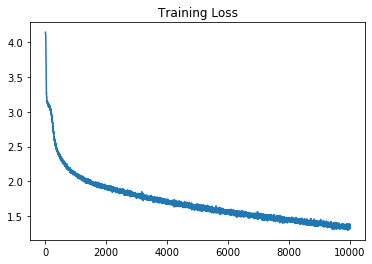

In [20]:
plt.plot(loss_history)
plt.title("Training Loss")
plt.show()

In [ ]:
RNN.save(current_path + "models/text_generator_RNN_00.h5")

In [22]:
generator = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(1, None)),
    
    LSTM(len_input, return_sequences = True, stateful=True),
    
    Dense(hidden_size, activation = relu), 
    
    Dense(vocab_size)
])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 250)            15750     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1000)           5004000   
_________________________________________________________________
dense_2 (Dense)              (1, None, 250)            250250    
_________________________________________________________________
dense_3 (Dense)              (1, None, 63)             15813     
Total params: 5,285,813
Trainable params: 5,285,813
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Import trained weights from RNN to generator
generator.set_weights(RNN.get_weights())

In [ ]:
def generate_text(start_string, num_generate = 1000, temperature = 1.0):
    
    # Vectorize input string
    input_eval = [char2idx[s] for s in start_string]  
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_generated = [] # List to append predicted chars 
    
    idx2char = { v: k for k, v in char2idx.items() }  # invert char-index mapping
    
    generator.reset_states()
    
    for i in range(num_generate):
        predictions = generator(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        # sample next char based on distribution and temperature
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
        
    return (start_string + ''.join(text_generated))
